In [120]:
%load_ext autoreload
%autoreload 2

from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching  import \
    ConditionalLSTMTSPostMeanScoreMatching

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [122]:
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSScoreMatching import ConditionalLSTMTSScoreMatching
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import get_config as get_config
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data import get_config as get_config
config = get_config()
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

Using CPU



0.9928886503366839

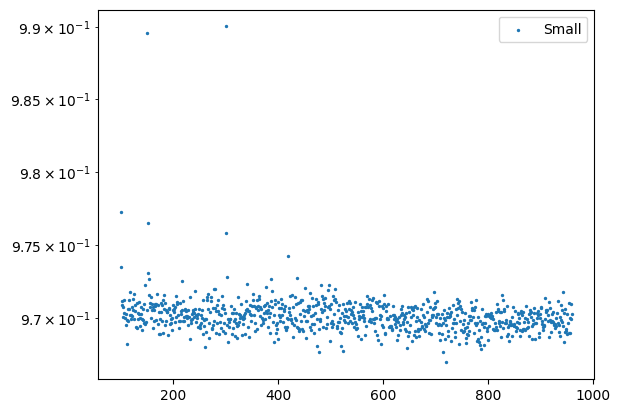

In [123]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f))
start_idx = 100
plt.scatter(np.arange(start_idx, losses.shape[0]), losses[start_idx:],s=2, label="Small")
#plt.hlines(np.sqrt(config.deltaT), xmin = start_idx, xmax=losses.shape[0]-start_idx, color="red")
plt.yscale("log")
plt.legend()
losses[-1]/losses[start_idx]

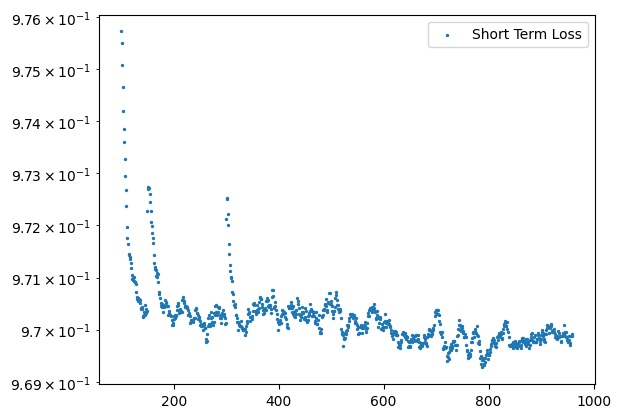

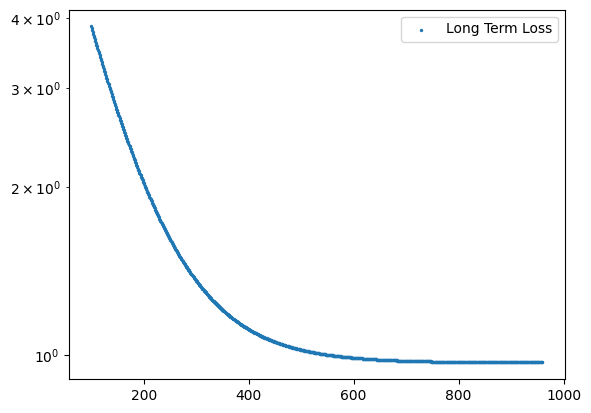

In [124]:
start_idx = 100
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9   # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)

# Compute EMAs
short_term_ema = compute_ema(losses, beta_short)
long_term_ema = compute_ema(losses, beta_long)
plt.scatter(np.arange(start_idx, short_term_ema.shape[0]), (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.scatter(np.arange(start_idx, long_term_ema.shape[0]), (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [125]:
from src.generative_modelling.data_processing import prepare_recursive_scoreModel_data
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Hook function to capture activations
def hook_fn_lstm(feature_history,module, input, output):
    # Store the output activations (hidden states)
    # TODO: This is only valid for RNN feature vectors
    output = output[0][:, :-1, :]
    B, T = output.shape[0], output.shape[1]
    output = output.reshape(B * T, 1, -1)
    feature_history.append(output.detach().cpu().numpy())

# Hook function to capture activations
def hook_fn_input_projection(feature_history,module, input, output):
    # Store the output activations (hidden states)
    feature_history.append(output.detach().cpu().numpy())


# Assuming you have a function that can load the model at a given epoch
def load_model_at_epoch(config, Nepoch):
    # Fix the number of training epochs and training loss objective loss
    model = ConditionalLSTMTSPostMeanScoreMatching(*config.model_parameters).to(device)
    model.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(Nepoch)))
    return model


def create_historical_vectors(model, init_state, device, batch):
        """
        Create history vectors using LSTM architecture
            :return: History vectors for each timestamp
        """
        # dbatch = torch.cat([torch.zeros((batch.shape[0], 1, batch.shape[-1])).to(batch.device), batch], dim=1)
        # batch shape (N_batches, Time Series Length, Input Size)
        # hidden states: (D*NumLayers, N, Hidden Dims), D is 2 if bidirectional, else 1.
        init_state = init_state.to(batch.device).view(1, 1, batch.shape[-1])  # Reshape to (1, 1, D)
        init_state = init_state.expand(batch.shape[0], -1, -1)  # Expand to (B, 1, D)
        dbatch = torch.cat([init_state, batch], dim=1)
        dbatch = dbatch.cumsum(dim=1)
        if type(device) == int:
            output, (hn, cn) = (model.module.rnn(dbatch, None))
        else:
            output, (hn, cn) = (model.rnn(dbatch, None))
        return output[:, :-1, :]


def extract_features(model, diffusion, init_state,data_loader, device):
    """Extract features from the model during evaluation"""
    model.eval()
    with torch.no_grad():
        timesteps = torch.linspace(config.train_eps, end=config.end_diff_time, steps=config.max_diff_steps)
        for x0s in (iter(data_loader)):
            x0s = x0s[0].to(device)

            # Generate history vector for each time t for a sample in (batch_id, t, numdims)
            features = create_historical_vectors(model=model, init_state=init_state, device=device, batch=x0s)
            diff_times = timesteps[torch.randint(low=0, high=config.max_diff_steps, dtype=torch.int32,
                                                 size=x0s.shape[0:2]).long()].view(x0s.shape[0], x0s.shape[1],
                                                                                   *([1] * len(x0s.shape[2:]))).to(device)
            # Diffusion times shape (Batch Size, Time Series Sequence, 1)
            # so that each (b, t, 1) entry corresponds to the diffusion time for timeseries "b" at time "t"
            eff_times = diffusion.get_eff_times(diff_times)
            # Each eff time entry corresponds to the effective diffusion time for timeseries "b" at time "t"
            xts, target_scores = diffusion.noising_process(x0s, eff_times)
            B, T, D = xts.shape
            xts = xts.reshape(B * T, 1, -1)
            features = features.reshape(B * T, 1, -1)
            target_scores = target_scores.reshape(B * T, 1, -1)
            diff_times = diff_times.reshape(B * T)
            eff_times = torch.cat([eff_times]*D, dim=2).reshape(target_scores.shape)
            model.forward(inputs=xts, conditioner=features, times=diff_times, eff_times=eff_times)
    return None

def per_model_features(model, hook_fn, hook_fn_choice, feature_history, data_loader, device, diffusion, init_state):
        features_per_epoch = []
        # Register hook to capture activations from the RNN layer (e.g., 'self.rnn')
        hooked_fn = partial(hook_fn[hook_fn_choice], features_per_epoch)
        # Load model at the current epoch
        # Choose the "MODULE" from print(model_at_epoch) here (in this case RNN)
        if hook_fn_choice == 0:
            hook = model.rnn.register_forward_hook(hooked_fn)
        elif hook_fn_choice == 1:
            hook = model.input_projection.register_forward_hook(hooked_fn)
        # Extract features from the model at this epoch
        extract_features(model=model, data_loader=data_loader, device=device, diffusion=diffusion, init_state=init_state)
        hook.remove()
        feature_history.append(np.concatenate(features_per_epoch, axis=0)[np.newaxis,:])



In [126]:
import pyperclip
epoch = 150
model_at_epoch = load_model_at_epoch(Nepoch=epoch, config=config)
for name, layer in model_at_epoch.named_modules():
    #print(f"Layer Name: {name}, Layer Type: {type(layer)}")
    pyperclip.copy(str(model_at_epoch))
    print(model_at_epoch)

ConditionalLSTMTSPostMeanScoreMatching(
  (rnn): LSTM(1, 20, batch_first=True)
  (input_projection): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
  (diffusion_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=128, out_features=64, bias=True)
    (projection2): Linear(in_features=64, out_features=64, bias=True)
  )
  (cond_upsampler): CondUpsampler(
    (linear1): Linear(in_features=20, out_features=2, bias=False)
    (linear2): Linear(in_features=2, out_features=1, bias=False)
  )
  (residual_layers): ModuleList(
    (0): ResidualBlock(
      (dilated_conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conditioner_projection): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
      (diffusion_projection): Linear(in_features=64, out_features=8, bias=True)
      (output_projection): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock(
      (dilated_conv): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  

In [177]:
from functools import partial

training_size = int(config.batch_size)
data = np.load(config.data_path, allow_pickle=True)
data = np.concatenate([data[:, [0]]-config.initState, np.diff(data, axis=1)], axis=1)
data = np.atleast_3d(data[:training_size, :])
assert (data.shape == (training_size, config.ts_length, config.ts_dims))
data_loader = prepare_recursive_scoreModel_data(data=data, batch_size=config.batch_size, config=config)

# Example usage for multiple epochs
epochs = [300, 960]#, 1440, 1920, 2920, 6920, 8190, 12920]  # Epochs of the models you want to check
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)
if isinstance(config.initState, float):
    init_state = torch.Tensor([config.initState])
else:
    init_state = torch.Tensor(config.initState)

hook_fn = [hook_fn_lstm, hook_fn_input_projection]
hook_fn_choice = 0
# Store features over different epochs
feature_history = []
# Iterate over the models saved at specific epochs
for epoch in epochs:
    model_at_epoch = load_model_at_epoch(Nepoch=epoch, config=config)
    per_model_features(model=model_at_epoch, hook_fn=hook_fn, hook_fn_choice=hook_fn_choice, feature_history=feature_history, data_loader=data_loader, device=device, diffusion=diffusion, init_state=init_state)
# Combine features and labels across all epochs
feature_history = np.concatenate(feature_history, axis=0)

Total Number of Datapoints 256 :: DataLoader Total Number of Datapoints 256


In [216]:
training_size = int(config.batch_size)
data = np.load(config.data_path, allow_pickle=True)
data = np.concatenate([data[:, [0]]-config.initState, np.diff(data, axis=1)], axis=1)
data = np.atleast_3d(data[:training_size, :])
assert (data.shape == (training_size, config.ts_length, config.ts_dims))
init_state = torch.Tensor([config.initState]).to(device).view(1, 1, config.ts_dims)  # Reshape to (1, 1, D)
init_state = init_state.expand(config.batch_size, -1, -1)  # Expand to (B, 1, D)
dbatch = torch.cat([init_state, torch.Tensor(data)], dim=1).cumsum(dim=1)[:, :-1,:]
dbatch.shape, data.shape

(torch.Size([256, 256, 1]), (256, 256, 1))

In [224]:
sim_data_tensor = dbatch[:10000, :, 0]
print(sim_data_tensor.shape)
dX = 1 / 1000
errs_with_avg = {}
errs_wo_avg = {}
for i in range(sim_data_tensor.shape[0]):
    for j in range(sim_data_tensor.shape[1]):
        x = sim_data_tensor[i, j]
        td = -(4.*config.quartic_coeff * np.power(x, 3) + 2.*config.quad_coeff * x + config.const).numpy()*config.deltaT
        if j != config.ts_length - 1:
            if x not in errs_wo_avg.keys():
                    errs_wo_avg.update({x.item(): [np.power(data[i, j+1][0]-td, 2)]})
            else:
                errs_wo_avg[x.item()].append(np.power(data[i, j+1][0]-td, 2))
        xmin = x - dX
        xmax = x + dX
        # Compute the mask over the entire sim_data matrix
        mask = (sim_data_tensor >= xmin) & (sim_data_tensor <= xmax)
        # Get indices where mask is True (each index is [i, j])
        indices = mask.nonzero(as_tuple=False)
        mean = 0.
        num = 0
        for idx in indices:
            if idx[1] != config.ts_length - 1:
                mean += data[idx[0], idx[1]+1]
                num += 1
        mean /= num
        if j != config.ts_length - 1:
            if x not in errs_with_avg.keys():
                    errs_with_avg.update({x.item(): [np.power(mean[0]-td, 2)]})
            else:
                errs_with_avg[x.item()].append(np.power(mean[0]-td, 2))

torch.Size([256, 256])


In [ ]:
keys = np.array(sorted(errs_wo_avg.keys()))  # Sorted keys
means_wo_avg = np.array([np.mean(errs_wo_avg[k]) for k in keys])
stds_wo_avg = np.array([np.std(errs_wo_avg[k]) for k in keys])
keys = np.array(sorted(errs_with_avg.keys()))  # Sorted keys
means_with_avg = np.array([np.mean(errs_with_avg[k]) for k in keys])
stds_with_avg = np.array([np.std(errs_with_avg[k]) for k in keys])

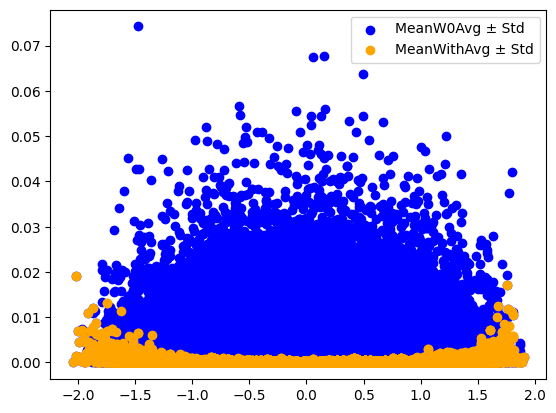

In [238]:
keys = np.array(sorted(errs_wo_avg.keys()))  # Sorted keys
plt.scatter(keys, means_wo_avg, color="blue",label="MeanW0Avg ± Std")
plt.vlines(keys, means_wo_avg - stds_wo_avg, means_wo_avg + stds_wo_avg, color='blue', alpha=0.5)
keys = np.array(sorted(errs_with_avg.keys()))  # Sorted keys
plt.scatter(keys, means_with_avg, color="orange",label="MeanWithAvg ± Std")
plt.vlines(keys, means_with_avg - stds_with_avg, means_with_avg + stds_wo_avg, color='blue', alpha=0.5)
plt.legend()
plt.show()
plt.close()

In [129]:
rmses = {}
for Nepoch in epochs:
    if "PMS" in config.scoreNet_trained_path:
        model_type = "PMS"
    elif "PM" in config.scoreNet_trained_path:
        model_type = "PM"
    else:
        model_type = ""
    if "fQuadSinHF" in config.data_path:
        file_path = (
                project_config.ROOT_DIR + f"experiments/results/TS{model_type}_LSTM_fQuadSinHF_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.deltaT:.3e}dT_{config.beta_max:.1e}betaMax_").replace(
            ".", "")
    elif "fBiPotSmall" in config.data_path:
        file_path = (
                project_config.ROOT_DIR + f"experiments/results/TS{model_type}_LSTM_fBiPotSmall_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.max_diff_steps}DiffSteps_").replace(
            ".", "")
    elif "fBiPot" in config.data_path:
        file_path = (
                project_config.ROOT_DIR + f"experiments/results/TS{model_type}_LSTM_fBiPot_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_{config.t0}t0_{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.deltaT:.3e}dT_{config.beta_max:.1e}betaMax_").replace(
            ".", "")
    muhats = torch.Tensor(np.load(file_path+"muhats.npy"))
    Xshape = muhats.shape[0]
    if "fQuadSinHF" in config.data_path:
        if config.deltaT > 1/(32*256):
            Xs = torch.linspace(-1.2, 1.2, steps=Xshape)
        else:
            Xs = torch.linspace(-.4, .4, steps=Xshape)
        ts_type = "fQuadSinHF"
    elif "fBiPot" in config.data_path:
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
        ts_type="fBiPot"
    if model_type == "":
        model_type="Standard"
    assert (config.max_diff_steps == 10000)
    if "fQuadSin" in config.data_path:
        true_drifts = -2.*config.quad_coeff * Xs.unsqueeze(-1) + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*Xs).numpy()
    elif "BiPot" in config.data_path:
        true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
    mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
    rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
    rmses.update({Nepoch: round(rmse, 4)})
rmses

{300: 0.8077, 960: 0.181}

In [130]:
def plot_feature_evolution(feature_history, epochs, method='TSNE', perplexity=30):
    """Plot feature evolution using t-SNE or PCA"""
    #assert (feature_history.shape == (len(epochs), training_size*config.ts_length, 1, config.lstm_hiddendim))
    red_features = []
    for i in range(feature_history.shape[0]):
        features_per_epoch = np.squeeze(feature_history[i, :, :, :])
        print(features_per_epoch.shape)
        #assert (features_per_epoch.shape == (training_size*config.ts_length, config.lstm_hiddendim))
        if method == 'TSNE':
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
            features_reduced = tsne.fit_transform(features_per_epoch)
        elif method == 'PCA':
            pca = PCA(n_components=2)
            features_reduced = pca.fit_transform(features_per_epoch)
        else:
            raise ValueError("Method should be 'TSNE' or 'PCA'")
        red_features.append(features_reduced)
    # Plot the features
    fig, ax = plt.subplots(figsize=(14,9))
    norm = plt.Normalize(vmin=min(rmses.values()), vmax=max(rmses.values()))
    cmap = plt.cm.viridis  # You can use other colormaps like 'coolwarm', 'plasma', etc.
    for i in range(len(red_features)):
        rmse_value = rmses[epochs[i]]  # Get the RMSE for the current epoch
        color = cmap(norm(rmse_value))  # Normalize and map RMSE value to color
        ax.scatter(red_features[i][:, 0], red_features[i][:, 1], alpha=0.5, label=f"Epoch: RMSE {epochs[i]}", color=color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Empty array to avoid warnings
    plt.colorbar(sm, ax=ax,label="RMSE Value")
    plt.legend()
    plt.xlabel("Reduced Dim 1")
    plt.ylabel("Reduced Dim 2")
    plt.title(f"Features Evolution")
    plt.show()
    plt.close()

In [131]:
epochs[1:6]

[960]

(2560, 20)
(2560, 20)


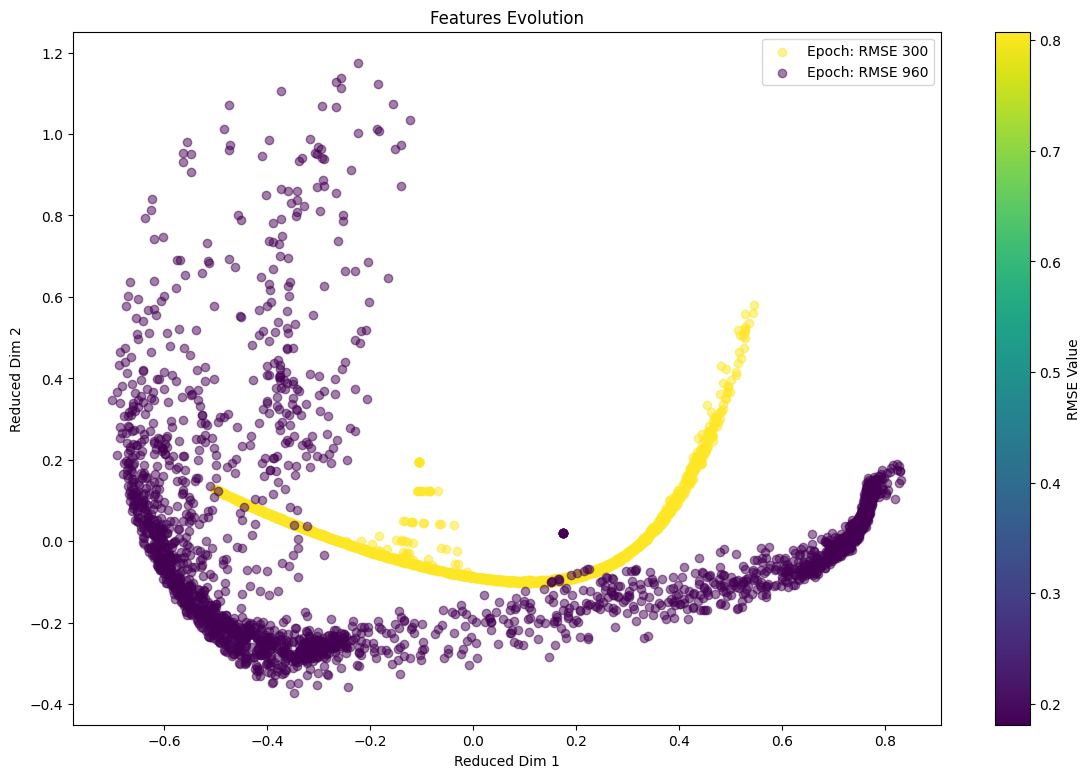

In [132]:
plot_feature_evolution(feature_history=feature_history[:,:,:,:], epochs=epochs[:], method="PCA")

In [133]:
# Could model averaging be a solution? --> doesn't seem so
"""
import torch

def average_checkpoints(epochs, device="cpu"):

    avg_state_dict = None
    num_checkpoints = len(epochs)

    for epoch in epochs:
        checkpoint = torch.load(config.scoreNet_trained_path + "_NEp" + str(epoch))
        # If your checkpoint dictionary has a key for the model state dict, adjust here:
        state_dict = checkpoint.get("model_state_dict", checkpoint)

        # On the first checkpoint, initialize avg_state_dict with the same keys and values.
        if avg_state_dict is None:
            avg_state_dict = {k: v.float() for k, v in state_dict.items()}
        else:
            for k, v in state_dict.items():
                avg_state_dict[k] += v.float()

    # Divide by the number of checkpoints to get the average
    for k in avg_state_dict:
        avg_state_dict[k] /= num_checkpoints
    model = ConditionalLSTMTSPostMeanScoreMatching(*config.model_parameters).to(device)
    # Load the averaged state dict into the model
    model.load_state_dict(avg_state_dict)
    return model

# Now you can use averaged_model for evaluation or further analysis.

averaged_model = average_checkpoints(epochs[:4], device="cpu")

In [134]:
from experiments.generative_modelling.RecursiveVPSDE.ParameterEstimation.PM.drifts_TSPM_LSTM_fBiPot import LSTM_1D_drifts
mu_hats = LSTM_1D_drifts(PM=averaged_model, config=config)
print(mu_hats.shape)

Beta Min :  0.0
Using CPU

/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_PM_TSM_2LFac_fBiPot_VPSDE_H50e-01_T256_Ndiff10000_Tdiff1000e+00_trainEps1e-04_BetaMax20e+01_BetaMin00e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_025a_-05b_00c_LSTM_H20_Nly1_tl110
(256, 1, 100)


In [138]:
muhats = mu_hats[:, -1, :].reshape(mu_hats.shape[0], mu_hats.shape[-1]*1).mean(axis=-1)
rmse = rmse_ignore_nans(true_drifts, muhats).astype(np.float64)
rmse

12.724745989279013

In [ ]:
per_model_features(model=model_at_epoch, hook_fn=hook_fn, hook_fn_choice=hook_fn_choice, feature_history=feature_history, data_loader=data_loader, device=device, diffusion=diffusion, init_state=init_state)"""

(10, 256, 1)